# Seminar (Week 3)

Dataset: https://disk.yandex.ru/d/B-bVBC3_1qQltw

In [ ]:
import dataclasses
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib

from IPython.display import clear_output

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/B-bVBC3_1qQltw'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O biometry_sem.tar.gz "{download_url}"
!mkdir data_sem
!tar -xf biometry_sem.tar.gz -C data_sem

In [3]:
DATA = 'data_sem'
DEVICE = 'mps'
TARGETS = os.path.join(DATA, 'targets.csv')
IN_DIM = 40

In [4]:
class Dataset(torch_data.Dataset):
    @dataclasses.dataclass
    class Item:
        feats: torch.tensor
        speaker: int
        age: int
        gender: int
        room: int

    def __init__(self, transform: nn.Module, speakers=(1, 2, 3), genders=(0, 1)):
        targets = pd.read_csv(TARGETS)
        self._speakers = {}
        self._data = []
        for _, row in tqdm.tqdm(targets.iterrows(), total=len(targets)):
            if int(row.speaker.split('_')[0]) not in speakers:
                continue
            if row.gender not in genders:
                continue
            path = os.path.join(DATA, row.audio)
            wav = torchaudio.load(path)[0]
            feats = transform(wav)[0]
            speaker = self._speakers.get(row.speaker, len(self._speakers))
            if speaker not in self._speakers:
                self._speakers[row.speaker] = len(self._speakers)
            self._data.append(self.Item(feats, speaker, row.age, row.gender, int(row.speaker.split('_')[0])))

    def __getitem__(self, idx):
        return self._data[idx]
    
    def __len__(self):
        return len(self._data)
    
    def speakers(self):
        return len(self._speakers)
    
def collate_fn(batch: list[Dataset.Item]):
    feats = [item.feats for item in batch]
    max_len = max([feat.shape[1] for feat in feats])
    X = torch.zeros((len(batch), IN_DIM, max_len))
    for idx, feat in enumerate(feats):
        X[idx,:,:feat.shape[1]] = feat
    Y = torch.tensor([item.speaker for item in batch], dtype=torch.long, device=DEVICE)
    age = [item.age for item in batch]
    gender = [item.gender for item in batch]
    room = [item.room for item in batch]
    return X.to(DEVICE), Y, age, gender, room

In [5]:
dataset = Dataset(torchaudio.transforms.MFCC(n_mfcc=40))

/Users/dlifantyev/prsnl/speech_course/.venv/lib/python3.13/site-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


  0%|          | 0/16260 [00:00<?, ?it/s]

### Train model

Train simple model for biometrics classification:

In [ ]:
class Model(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim=128, kernel_size=7):
        super().__init__()
        self._aug = nn.Sequential(
            torchaudio.transforms.FrequencyMasking(freq_mask_param=5),
            torchaudio.transforms.TimeMasking(time_mask_param=20),
        )
        self._body = nn.Sequential(
            nn.Conv1d(in_dim, hidden_dim, kernel_size),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(hidden_dim, hidden_dim, kernel_size),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(hidden_dim, hidden_dim, kernel_size),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(hidden_dim, hidden_dim, kernel_size),
            nn.AdaptiveAvgPool1d(1),
        )  # <YOUR CODE IS HERE>
        self._head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )  # <YOUR CODE IS HERE>

    def forward(self, X):
        with torch.no_grad():
            if self.training: X = self._aug(X)

        emb = self._body(X).squeeze(2)  # <YOUR CODE IS HERE>
        return self._head(emb), emb

In [ ]:
def train(model: nn.Module, epochs=10, batch_size=256):
    opt = optim.Adam(model.parameters())
    data = torch_data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    losses = []
    accs = []
    for _ in range(epochs):
        loss_sum = 0
        acc_sum = 0
        batches = 0
        for X, Y, _, _, _ in tqdm.tqdm(data):
            logits, _ = model.forward(X)
            logits = logits.squeeze()
            loss = F.cross_entropy(logits, Y)
            with torch.no_grad():
                acc = torch.sum(torch.argmax(logits, dim=-1) == Y) / X.shape[0]
            opt.zero_grad()
            loss.backward()
            opt.step()
            loss_sum += loss.item()
            acc_sum += acc.item()
            batches += 1
        losses.append(loss_sum / batches)
        accs.append(acc_sum / batches)
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(losses)
        axis[1].plot(accs)
        plt.show()
        print('Train loss:', losses[-1], 'Accuracy:', accs[-1])

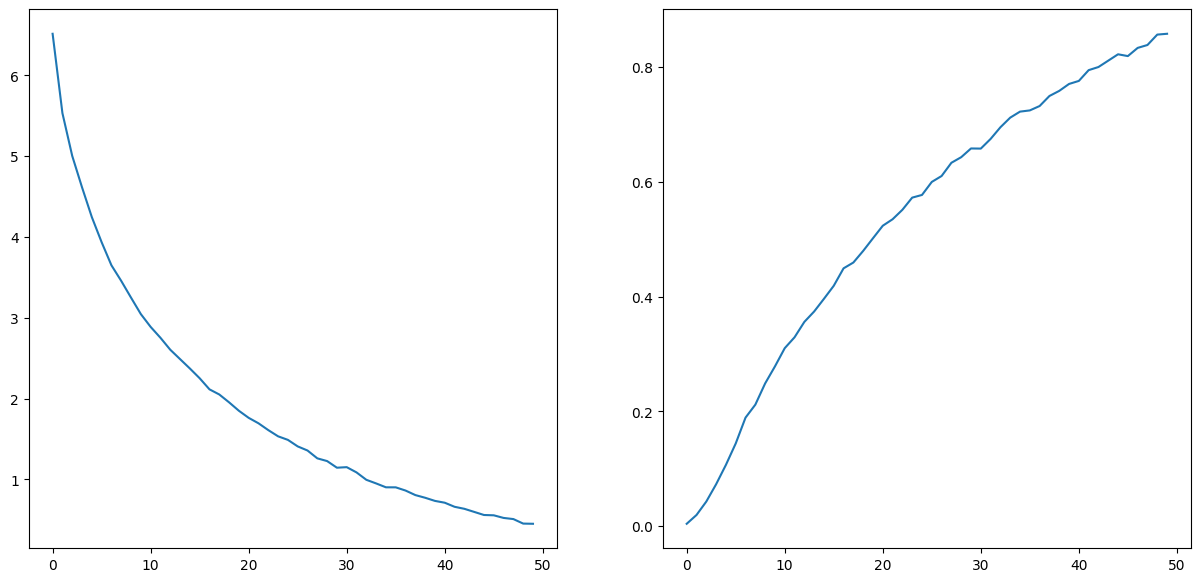

Train loss: 0.4515392235480249 Accuracy: 0.8576789628714323


In [8]:
model = Model(IN_DIM, dataset.speakers()).to(DEVICE)
train(model, epochs=50)

### Prepare embeddings

Prepare embeddings of trained model, project to lower dimensional space.

In [9]:
embeddings = []
ages = []
genders = []
rooms = []
data = torch_data.DataLoader(dataset, batch_size=256, collate_fn=collate_fn)
model.eval()
with torch.no_grad():
    for X, _, age, gender, room in tqdm.tqdm(data):
        _, emb = model.forward(X)
        embeddings.extend(emb.squeeze().cpu().data.numpy())
        ages.extend(age)
        genders.extend(gender)
        rooms.extend(room)

  0%|          | 0/64 [00:00<?, ?it/s]

In [10]:
# <YOUR CODE IS HERE>
pca = PCA(n_components=2)
pca.fit(embeddings)
emb2dim = pca.transform(embeddings)

### Plot different classes

Plot embeddings for different classes by age, gender and room conditions

[ 8.55150402 17.30386065]
[ -5.42592414 -10.97928915]


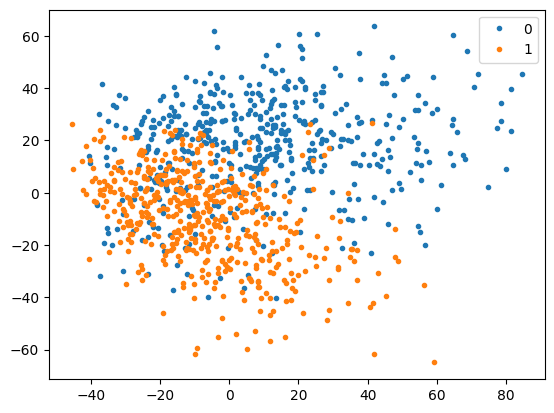

In [11]:
# gender
for gen in [0, 1]:
    cur_emb = [emb for emb, gender in zip(emb2dim, genders) if gender == gen]
    print(np.mean(cur_emb, axis=0))
    x_limits = np.quantile([x for x, _ in cur_emb], [0.01, 0.99])
    y_limits = np.quantile([y for _, y in cur_emb], [0.01, 0.99])
    cur_emb = np.array(
        [(x, y) for x, y in cur_emb if x_limits[0] <= x <= x_limits[1] and y_limits[0] <= y <= y_limits[1]]
    )
    indexes = np.random.choice(np.arange(len(cur_emb)), size=500, replace=False)
    cur_emb = cur_emb[indexes]
    plt.plot([x for x, _ in cur_emb], [y for _, y in cur_emb], '.', label=gen)
plt.legend()
plt.show()

[-18.53719304 -12.9680524 ]
[-5.82828355 -9.56693741]
[  1.03725935 -10.82505079]


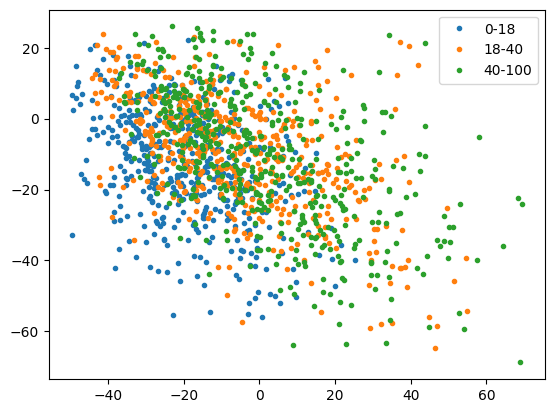

In [17]:
for age_lo, age_hi in [(0, 18), (18, 40), (40, 100)]:
    cur_emb = [emb for emb, gender, age in zip(emb2dim, genders, ages) if age_lo <= age < age_hi and gender == 1]
    print(np.mean(cur_emb, axis=0))
    x_limits = np.quantile([x for x, _ in cur_emb], [0.01, 0.99])
    y_limits = np.quantile([y for _, y in cur_emb], [0.01, 0.99])
    cur_emb = np.array(
        [(x, y) for x, y in cur_emb if x_limits[0] <= x <= x_limits[1] and y_limits[0] <= y <= y_limits[1]]
    )
    indexes = np.random.choice(np.arange(len(cur_emb)), size=500, replace=False)
    cur_emb = cur_emb[indexes]
    plt.plot([x for x, _ in cur_emb], [y for _, y in cur_emb], '.', label=f'{age_lo}-{age_hi}')
plt.legend()
plt.show()